In [9]:
# Mounting the google drive for easy access of the dataset 
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AFgulcjvYhKCTBnknCKRwpN9vn2y8dB3vcKgSyuKubYF8GNIG6-Ovs
Mounted at /content/drive


In [1]:
# Path for Java
JAVA_HOME = "/usr/lib/jvm/java-8-openjdk-amd64"

In [2]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = JAVA_HOME

     |████████████████████████████████| 204.2MB 66kB/s 
     |████████████████████████████████| 204kB 41.2MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=020e73b889b94825301a773d2a451e366cc1c929e15756f535eb1ea5f89b2d24
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 39 not upgraded.
Need to get 35.8 MB of archives.
After this 

In [3]:
# Installing and importing the required python libraries
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
# import the SparkConfiguration and SparkContext
# if we wanted to change any configuration settings for this session only we would define them here
conf = (SparkConf()
        .setMaster("local")
        .setAppName("Recommender_System")
        .set("spark.executor.memory", "16G")
        .set("spark.driver.memory", "16G")
        .set("spark.executor.cores", "8"))
# create a SparkContext using the above configuration
sc = SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [6]:
spark

In [7]:
# this command shows the current configuration settings
sc._conf.getAll()

[('spark.master', 'local'),
 ('spark.driver.host', '0225f80b5def'),
 ('spark.driver.memory', '16G'),
 ('spark.executor.id', 'driver'),
 ('spark.driver.port', '33955'),
 ('spark.app.id', 'local-1599587121900'),
 ('spark.executor.memory', '16G'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.submit.pyFiles', ''),
 ('spark.app.name', 'Recommender_System'),
 ('spark.submit.deployMode', 'client'),
 ('spark.executor.cores', '8'),
 ('spark.ui.showConsoleProgress', 'true')]

load the dataset

In [24]:
# read in the dataset from google drive
rating = spark.read.load("/content/drive/My Drive/ratings.csv", 
                         format="csv", 
                         inferSchema="true", 
                         header="true"
                         )

In [25]:
# number of rows in the dataset
rating.count()

981756

In [26]:
rating.show()

+-----+-----+------+
|books|users|rating|
+-----+-----+------+
|    1|  314|     5|
|    1|  439|     3|
|    1|  588|     5|
|    1| 1169|     4|
|    1| 1185|     4|
|    1| 2077|     4|
|    1| 2487|     4|
|    1| 2900|     5|
|    1| 3662|     4|
|    1| 3922|     5|
|    1| 5379|     5|
|    1| 5461|     3|
|    1| 5885|     5|
|    1| 6630|     5|
|    1| 7563|     3|
|    1| 9246|     1|
|    1|10140|     4|
|    1|10146|     5|
|    1|10246|     4|
|    1|10335|     4|
+-----+-----+------+
only showing top 20 rows



# **Data Exploration**

Let's investigate the data and try to find and make some observations by looking at summary statistics

In [28]:
print ('Distinct values of ratings:')
print (rating.select('rating').distinct().rdd.map(lambda r: r[0]).collect())

Distinct values of ratings:
[1, 3, 5, 4, 2]


In [30]:
tmp1 = rating.groupBy("users").count().select('count').rdd.min()[0]
tmp2 = rating.groupBy("books").count().select('count').rdd.min()[0]
print ('For the users that rated books and the books that were rated:')
print ('Minimum number of ratings per User is {}'.format(tmp1))
print ('Minimum number of ratings per book is {}'.format(tmp2))

For the users that rated books and the books that were rated:
Minimum number of ratings per User is 2
Minimum number of ratings per book is 8


In [33]:
tmp1 = rating.groupBy("books").count().withColumnRenamed("count", "rating count")\
.groupBy("rating count").count().orderBy('rating count').first()[1]
tmp2 = rating.select('books').distinct().count()
print ('{} out of {} books are rated by only one user'.format(tmp1, tmp2))

1 out of 10000 books are rated by only one user


In [34]:
print ("Number of users who rated books:", rating.select('users').distinct().count())
print ("Number of rated books:", rating.select('books').distinct().count())

Number of users who rated books: 53424
Number of rated books: 10000


# **Summary of Descriptive Statistics**

In [36]:
rating.describe().toPandas()

,summary,books,users,rating
0,count,981756,981756,981756
1,mean,4943.275635697668,25616.759933221696,3.8565335989797873
2,stddev,2873.207414896197,15228.33882588251,0.9839408559620116
3,min,1,1,1
4,max,10000,53424,5


Converting Spark data to well-known Pandas could be done easily with toPandas() method:

In [37]:
# To access plotting libraries, we need to first transform our PySpark DataFrame into a Pandas DataFrame
Ratings_pdf = rating.toPandas() 

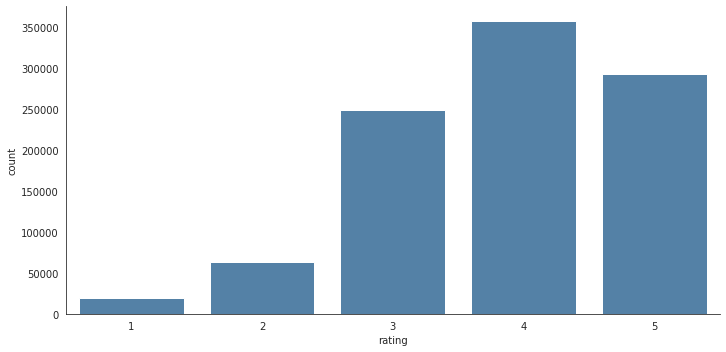

In [39]:
with sns.axes_style('white'):
    g = sns.catplot("rating",
                data=Ratings_pdf,
               kind="count", aspect=2,color='steelblue')

# **Splitting the dataset into Train and Test**

I will split the data into training/testing sets using a 70/30 random splits.
This is done to Train the model on train set and finally evaluate the model post predicting on the test set

In [40]:
data = rating.select("books", "users", "rating")

#divide data, 70% for training and 30% for testing
splits = data.randomSplit([0.7, 0.3])
train = splits[0].withColumnRenamed("rating", "label")
test = splits[1].withColumnRenamed("rating", "trueLabel")

#calculate number of rows
train_rows = train.count()
test_rows = test.count()
print ("number of training data rows:", train_rows, 
       ", number of testing data rows:", test_rows)

number of training data rows: 686866 , number of testing data rows: 294890


ALS

In [ ]:
from pyspark.ml.recommendation import ALS
als = ALS(maxIter=19, regParam=0.01, userCol="books", 
          itemCol="users", ratingCol="label")

#train our ALS model
model = als.fit(train)
print("Training is doneon the model")

Training is doneon the model


pred on test data

In [ ]:
prediction = model.transform(test)
print("testing is done on the model")

testing is done on the model


In [ ]:
prediction.show()

+-----+-----+---------+----------+
|books|users|trueLabel|prediction|
+-----+-----+---------+----------+
| 3435|  148|        3| 3.9737463|
| 5307|  148|        3| 2.5299137|
| 9077|  148|        3| 3.4599788|
| 7944|  148|        4|   4.25571|
| 7914|  148|        4| 3.8396463|
| 8679|  148|        4|  4.071889|
| 5407|  148|        4|  3.025085|
| 9837|  148|        3| 3.0923884|
| 3267|  148|        3| 3.5229692|
| 8968|  148|        4| 3.4324741|
| 8059|  148|        4|  3.507866|
| 7154|  148|        4| 4.1739225|
| 3961|  148|        4| 4.4313064|
| 2700|  148|        4| 3.6817708|
| 3345|  148|        4| 4.7206993|
| 7599|  463|        2| 2.5301554|
| 5327|  463|        4| 4.4965205|
| 1315|  463|        3| 4.6550274|
| 4586|  463|        3|   4.47713|
| 8822|  496|        4| 3.4542215|
+-----+-----+---------+----------+
only showing top 20 rows



In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(
    labelCol="trueLabel", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(prediction)
print ("Root Mean Square Error (RMSE):", rmse)

Root Mean Square Error (RMSE): nan


In [ ]:

prediction.count()
a = prediction.count()
print("number of original data rows: ", a)
#drop rows with any missing data
cleanPred = prediction.dropna(how="any", subset=["prediction"])
b = cleanPred.count()
print("number of rows after dropping data with missing value: ", b)
print("number of missing data: ", a-b)

number of original data rows:  295183
number of rows after dropping data with missing value:  293022
number of missing data:  2161


In [ ]:
rmse = evaluator.evaluate(cleanPred)
print ("Root Mean Square Error (RMSE):", rmse)

Root Mean Square Error (RMSE): 1.3139328571810402


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
param_grid = ParamGridBuilder() \
 .addGrid(als.rank, [10, 50, 75, 100]) \
 .addGrid(als.maxIter, [5, 50, 75, 100]) \
 .addGrid(als.regParam, [.01, .05, .1, .15]) \
 .build()
# Define evaluator as RMSE
evaluator = RegressionEvaluator(
    labelCol="trueLabel", predictionCol="prediction", metricName="rmse")
# Print length of evaluator
print ("Num models to be tested using param_grid: ", len(param_grid))

Num models to be tested using param_grid:  64


In [ ]:
cv = CrossValidator(estimator = als, 
 estimatorParamMaps = param_grid, 
 evaluator = evaluator, 
 numFolds = 5)
model = als.fit(train)
predictions = model.transform(test)
predictions.show(n = 10)

+-----+-----+---------+----------+
|books|users|trueLabel|prediction|
+-----+-----+---------+----------+
| 3435|  148|        3| 3.9737463|
| 5307|  148|        3| 2.5299137|
| 9077|  148|        3| 3.4599788|
| 7944|  148|        4|   4.25571|
| 7914|  148|        4| 3.8396463|
| 8679|  148|        4|  4.071889|
| 5407|  148|        4|  3.025085|
| 9837|  148|        3| 3.0923884|
| 3267|  148|        3| 3.5229692|
| 8968|  148|        4| 3.4324741|
+-----+-----+---------+----------+
only showing top 10 rows



Reco for all users

In [ ]:

ALS_recommendations = model.recommendForAllUsers(numItems = 10) 

In [ ]:
ALS_recommendations.show()

+-----+--------------------+
|books|     recommendations|
+-----+--------------------+
| 1580|[[52094, 7.558549...|
| 4900|[[41472, 8.907330...|
| 5300|[[18335, 6.807567...|
| 6620|[[23176, 9.188845...|
| 7240|[[24753, 7.729779...|
| 7340|[[24835, 7.295790...|
| 7880|[[17891, 7.354595...|
| 9900|[[44321, 6.535833...|
|  471|[[4923, 6.524211]...|
| 1591|[[51935, 6.665852...|
| 4101|[[46161, 8.302257...|
| 1342|[[41472, 7.678193...|
| 2122|[[6903, 7.044908]...|
| 2142|[[44141, 8.318434...|
| 7982|[[41728, 7.418365...|
| 8592|[[39287, 7.345355...|
| 9852|[[2929, 6.9944334...|
|  463|[[41085, 8.199598...|
|  833|[[20770, 6.357651...|
| 5803|[[24663, 7.045941...|
+-----+--------------------+
only showing top 20 rows

